In [1]:
import os

import inspect
import time
import warnings
import calendar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import LabelEncoder
import pytz
import scipy.stats as stats
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import optuna
from xgboost import plot_importance

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

C:\Users\Vamsi\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

from sklearn.metrics import mean_squared_log_error

def rmlse(y_true, y_pred):
    # Clip predictions to avoid negative values
    y_pred = np.clip(y_pred, 0, None)
    # Calculate mean squared log error
    msle = mean_squared_log_error(y_true, y_pred)
    # Return the root mean squared log error
    rmlse_value = np.sqrt(msle)
    return rmlse_value


In [3]:
df_train = pd.read_csv("data\\train.csv")
df_test = pd.read_csv("data\\test.csv")
df_holiday = pd.read_csv("data\holidays_events.csv")
df_oil = pd.read_csv("data\oil.csv")
df_stores = pd.read_csv("data\stores.csv")
df_transaction = pd.read_csv("data\\transactions.csv")

df_train


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [4]:
df_train = df_train.groupby(['date', 'store_nbr', 'family']).agg({
    'sales': 'sum',
    'onpromotion': 'sum'
}).reset_index()
#elimintaing duplicates
df_train

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,2013-01-01,1,BABY CARE,0.000,0
2,2013-01-01,1,BEAUTY,0.000,0
3,2013-01-01,1,BEVERAGES,0.000,0
4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...
3000883,2017-08-15,54,POULTRY,59.619,0
3000884,2017-08-15,54,PREPARED FOODS,94.000,0
3000885,2017-08-15,54,PRODUCE,915.371,76
3000886,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000,0


In [5]:
df_test = df_test.groupby(['date', 'store_nbr', 'family']).agg({
        'onpromotion': 'sum'
    }).reset_index()

In [6]:
df_train.isnull().sum()

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [7]:
df_train.nunique()

date             1684
store_nbr          54
family             33
sales          379610
onpromotion       362
dtype: int64

In [8]:
df_train.describe()

# we observe that mean is higher that median which means that a few high values are pushig the mean above in both cases



,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06
mean,2.750000e+01,3.577757e+02,2.602770e+00
std,1.558579e+01,1.101998e+03,1.221888e+01
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.400000e+01,0.000000e+00,0.000000e+00
50%,2.750000e+01,1.100000e+01,0.000000e+00
75%,4.100000e+01,1.958473e+02,0.000000e+00
max,5.400000e+01,1.247170e+05,7.410000e+02


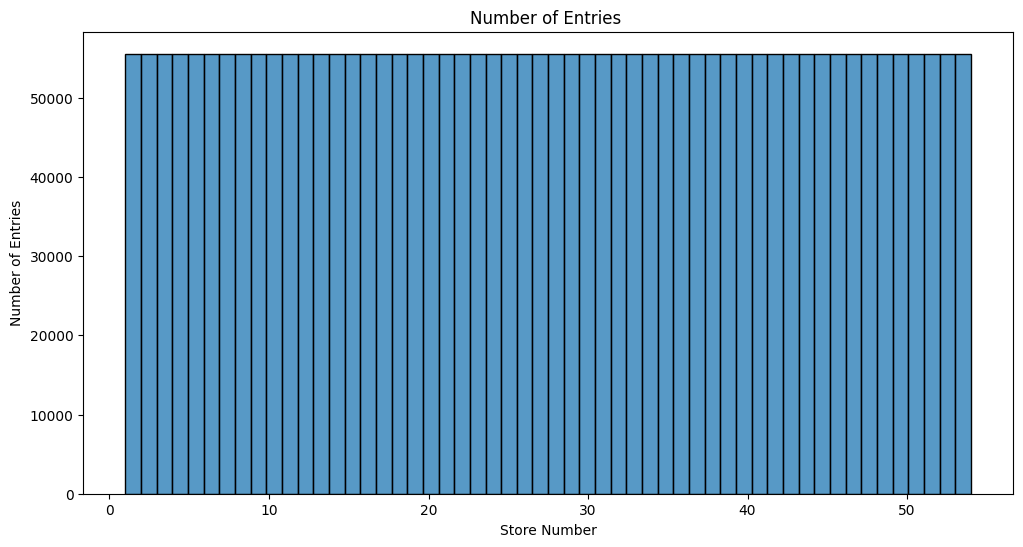

In [9]:
plt.figure(figsize=(12, 6))

sns.histplot(df_train["store_nbr"], bins=len(df_train["store_nbr"].unique()), kde=False)
plt.title("Number of Entries ")
plt.xlabel("Store Number")
plt.ylabel("Number of Entries")
plt.show()

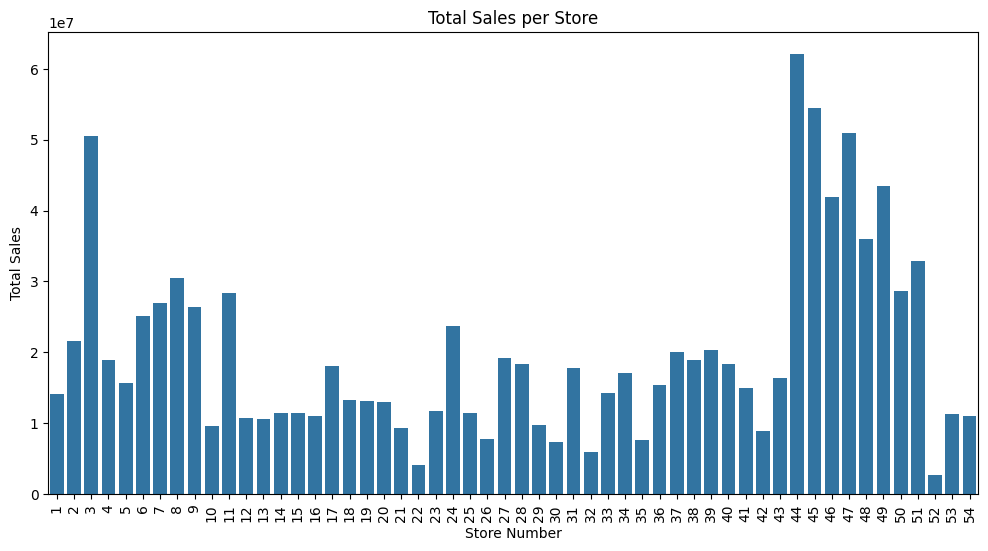

In [10]:
total_sales = df_train.groupby("store_nbr")["sales"].sum()
plt.figure(figsize=(12, 6))
sns.barplot(x=total_sales.index, y=total_sales.values)
plt.title("Total Sales per Store")
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.xticks(rotation=90)
plt.show()

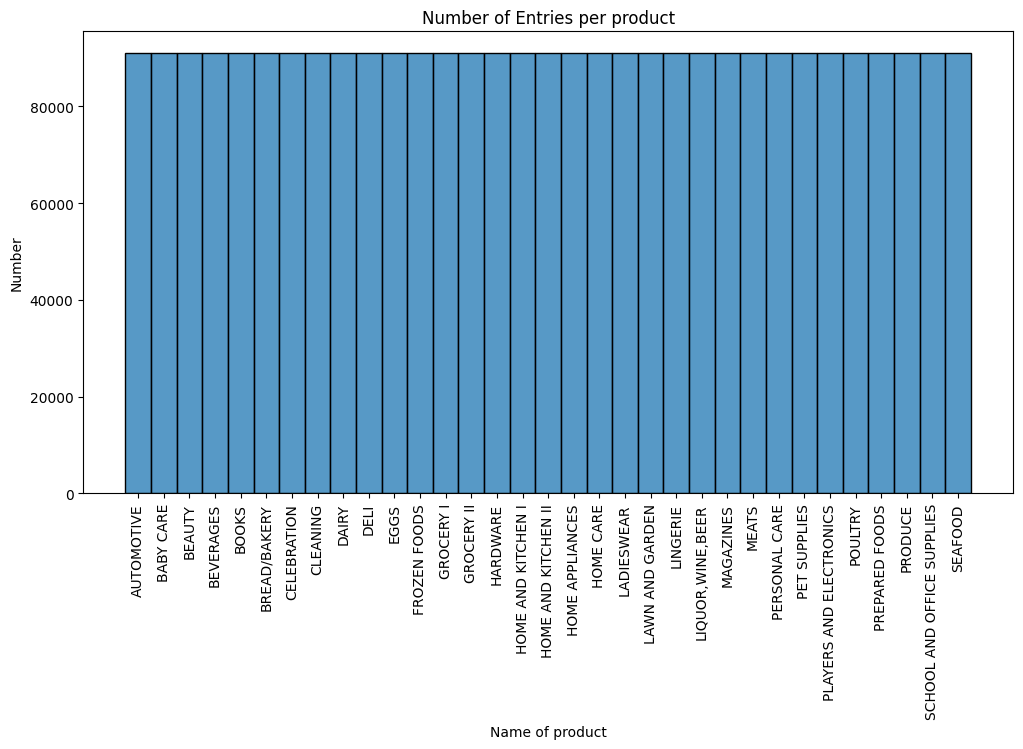

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(df_train["family"], bins=len(df_train["family"].unique()), kde=False)
plt.title("Number of Entries per product")
plt.xlabel("Name of product")
plt.ylabel("Number")
plt.xticks(rotation=90)
plt.show()

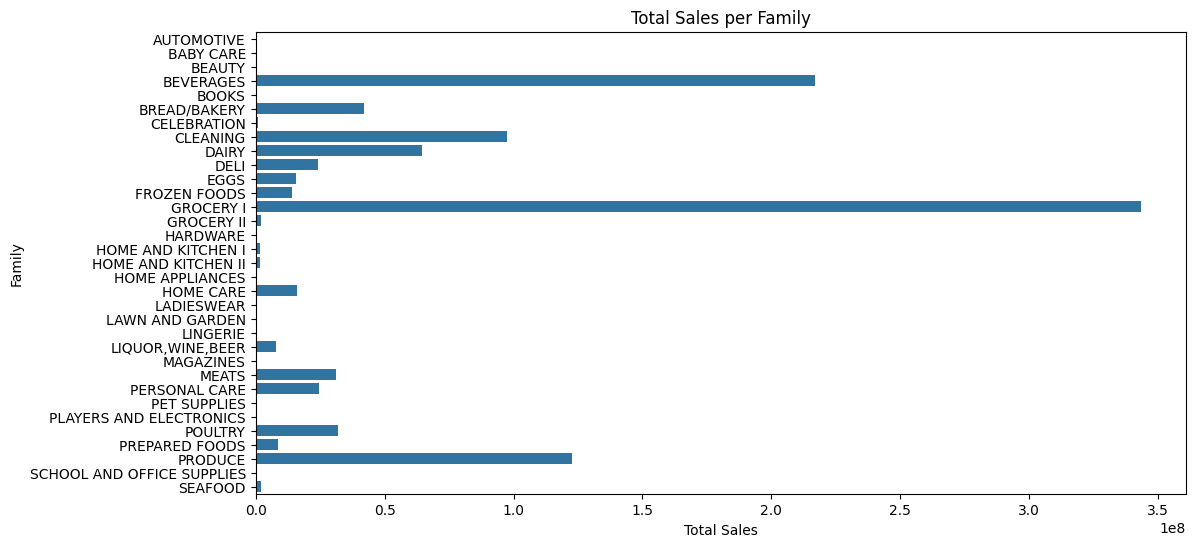

In [12]:
total_sales = df_train.groupby("family")["sales"].sum()


plt.figure(figsize=(12, 6))
sns.barplot(x=total_sales.values, y=total_sales.index, orient='h')
plt.title("Total Sales per Family")
plt.xlabel("Total Sales")
plt.ylabel("Family")
plt.show()


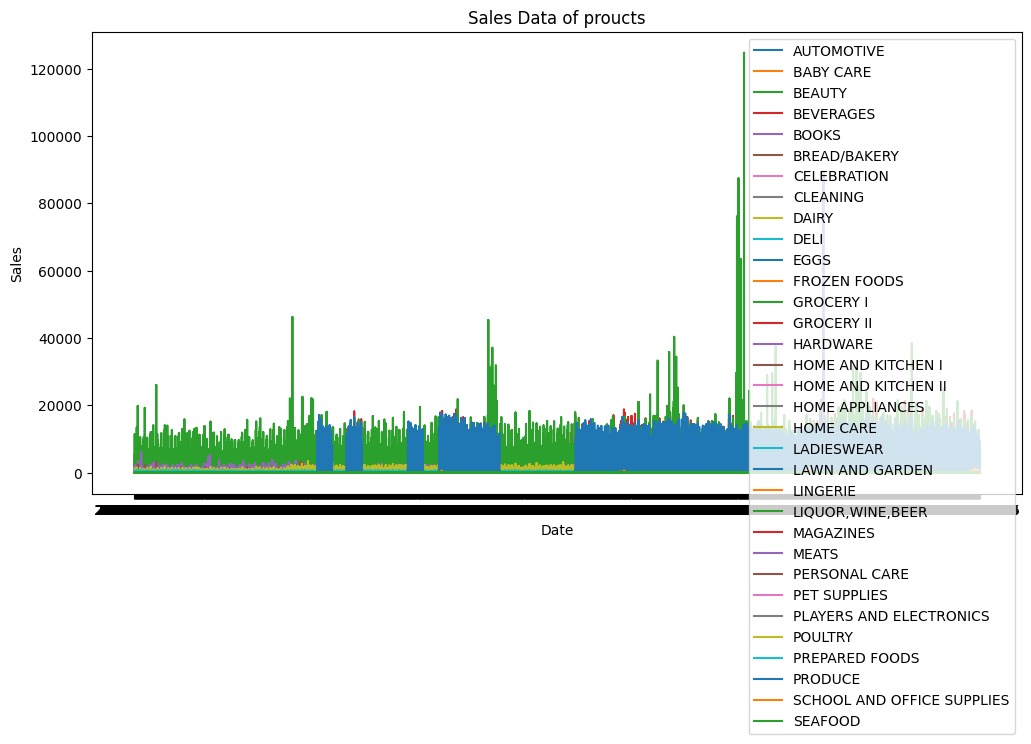

In [13]:
plt.figure(figsize=(12, 6))
for family in df_train['family'].unique():
    family_data = df_train[df_train['family'] == family]
    family_data.set_index('date', inplace=True)    
    plt.plot(family_data.index, family_data['sales'], label=family)
plt.legend()
plt.title('Sales Data of proucts')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

In [14]:
#observing the above graph we can conlclude that madnt askes didnt happen in the first half and can be discarded

In [15]:
print(df_stores.isnull().sum())

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


In [16]:
df_oil['date'] = pd.to_datetime(df_oil['date'])

In [17]:
df_oil = df_oil.rename(columns = {"dcoilwtico" : "price"})

In [18]:
# Assuming df_oil['date'] is already in datetime format
df_oil['month'] = df_oil['date'].dt.to_period('M')
df_oil['month_avg'] = df_oil.groupby('month')['price'].transform(lambda x: x.mean() if x.count() > 0 else 0)
df_oil['price'].fillna(df_oil['month_avg'], inplace=True)
df_oil.drop(['month', 'month_avg'], axis=1, inplace=True)


In [19]:
df_oil

,date,price
0,2013-01-01,94.756667
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-07,93.200000
...,...,...
1213,2017-08-25,47.650000
1214,2017-08-28,46.400000
1215,2017-08-29,46.460000
1216,2017-08-30,45.960000


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


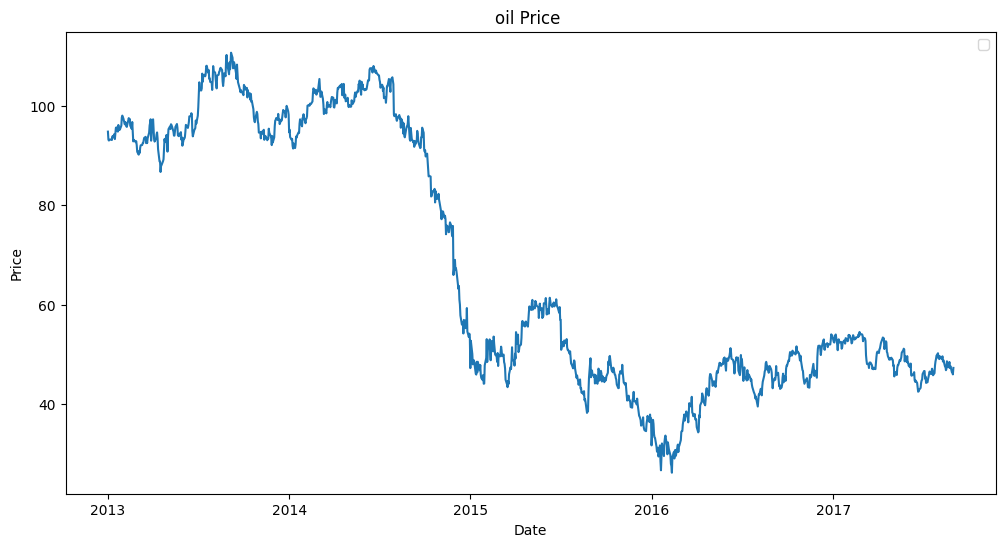

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(df_oil["date"], df_oil["price"])
plt.legend()
plt.title('oil Price ')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [21]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])
df_holiday['date'] = pd.to_datetime(df_holiday['date'])

df_train = df_train.merge(df_stores, how='left', on='store_nbr')
df_train = df_train.merge(df_oil, how='left', on='date')
df_train = df_train.merge(df_holiday, how='left', on='date')

df_test = df_test.merge(df_stores, how='left', on='store_nbr')
df_test = df_test.merge(df_oil, how='left', on='date')
df_test = df_test.merge(df_holiday, how='left', on='date')

In [22]:
df_test = df_test.drop(columns= ['type_x', 'locale', 'locale_name', 'description', 'transferred'])
df_train = df_train.drop(columns= ['type_x', 'locale', 'locale_name', 'description', 'transferred'])

In [23]:
df_train

,date,store_nbr,family,sales,onpromotion,city,state,cluster,price,type_y
0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,13,94.756667,Holiday
1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,13,94.756667,Holiday
2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,13,94.756667,Holiday
3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,13,94.756667,Holiday
4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,13,94.756667,Holiday
...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,54,POULTRY,59.619,0,El Carmen,Manabi,3,47.570000,Holiday
3054344,2017-08-15,54,PREPARED FOODS,94.000,0,El Carmen,Manabi,3,47.570000,Holiday
3054345,2017-08-15,54,PRODUCE,915.371,76,El Carmen,Manabi,3,47.570000,Holiday
3054346,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000,0,El Carmen,Manabi,3,47.570000,Holiday


In [24]:
df_test

,date,store_nbr,family,onpromotion,city,state,cluster,price,type_y
0,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,13,46.80,NaN
1,2017-08-16,1,BABY CARE,0,Quito,Pichincha,13,46.80,NaN
2,2017-08-16,1,BEAUTY,2,Quito,Pichincha,13,46.80,NaN
3,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,13,46.80,NaN
4,2017-08-16,1,BOOKS,0,Quito,Pichincha,13,46.80,NaN
...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,54,POULTRY,0,El Carmen,Manabi,3,47.26,NaN
28508,2017-08-31,54,PREPARED FOODS,0,El Carmen,Manabi,3,47.26,NaN
28509,2017-08-31,54,PRODUCE,1,El Carmen,Manabi,3,47.26,NaN
28510,2017-08-31,54,SCHOOL AND OFFICE SUPPLIES,0,El Carmen,Manabi,3,47.26,NaN


In [25]:
del df_holiday
del df_stores
del df_transaction
del df_oil


In [26]:
df_final = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [27]:
df_final.fillna(0, inplace=True)

In [28]:
train_data = df_final[df_final['date'] <= '2017-08-15'].copy()
test_data = df_final[df_final['date'] > '2017-08-15'].copy()

In [29]:

cat_features = ['family', 'city', 'state', 'type_y', 'cluster', 'store_nbr']

train_data_encoded = train_data
test_data_encoded = test_data


train_data_encoded[cat_features] = train_data_encoded[cat_features].astype(str)
test_data_encoded[cat_features] = test_data_encoded[cat_features].astype(str)


label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    train_data_encoded[col] = le.fit_transform(train_data[col])
    test_data_encoded[col] = le.transform(test_data[col])
    label_encoders[col] = le

In [30]:
train_data_encoded.drop(['date'], axis=1, inplace=True)
test_data_encoded.drop(['date'], axis=1, inplace=True)

In [31]:
correlation_matrix = train_data_encoded.corr()


correlation_with_sales = correlation_matrix['sales']

abs_sales = correlation_with_sales.abs()




In [32]:
X_train = train_data_encoded.drop(columns=['sales'])
y_train = train_data_encoded['sales']

X_test = test_data_encoded.drop(columns=['sales'])
y_test = test_data_encoded['sales']

In [33]:
subset_frac = 0.20
subset_size = int(len(train_data_encoded) * subset_frac)
subsample_train_data = train_data_encoded.iloc[-subset_size:]

In [34]:
X_subsample = subsample_train_data.drop(columns=["sales"])
y_subsample = subsample_train_data["sales"]

In [35]:
split_index = int(0.8 * len(X_subsample))
X_sub_train, X_sub_val = X_subsample.iloc[:split_index], X_subsample.iloc[split_index:]
y_sub_train, y_sub_val = y_subsample.iloc[:split_index], y_subsample.iloc[split_index:]

In [33]:
import xgboost as xgb


params = {
    'tree_method': 'hist',  
    'n_jobs': -1,  
    'objective': 'reg:squarederror',
    'n_estimators': 200,  
    'verbosity': 2,
    'learning_rate': 0.05,  
    'max_depth': 10,  
    'subsample': 0.8,  
    'colsample_bytree': 0.8,  
    'min_child_weight': 12,  
    'reg_lambda': 0.01,  
    'colsample_bynode': 0.5  
}


model = xgb.XGBRegressor(**params)

# Fit the model
model.fit(X_train, y_train, verbose=True)

# Make predictions
y_pred = model.predict(X_test)


error = rmlse(y_test, y_pred)

print("RMSLE Error:", error)


RMSLE Error: 4.498531553585999
